# Sentiment Analysis on selected migration related articles over time (2015-2018)

* The goal of this analysis is to find out which was the evolution of the sentiment projection regarding migration in the media, specifically, in articles from "Der Spiegel".
* We want to use a recurrent neural network model (LSTM) since we want to consider the history on the sentiment over the words/sentences within each article (i.e. if there is a negative estatment we want to consier its impact on the whole sentence).
* In this case we will use a LSTM pre-trained model. It was trained on the Amazon product review dataset introduced in McAuley et al. (2015) [1]. The dataset in de-duplicated form contains over 82 million product reviews from May 1996 to July 2014 amounting to over 38 billion training bytes. Training took one month across four NVIDIA Pascal GPUs, with our model processing 12,500 characters per second.
* The output of the model is the 4,096 hidden units from last layer. As reported in the paper for the binary version of the Stanford Sentiment Treebank (SST), the unit "2,388" contains the sentiment information (see distribution of values for positive and negative labels in the picture below). 
* The authors report two versions of the model, the first is based on [Tensor Flow](https://github.com/openai/generating-reviews-discovering-sentiment) and the second on [PyTorch](https://github.com/guillitte/pytorch-sentiment-neuron). In the current notebook both models will be QA with the sentences provided in [2].

[1] McAuley, Julian, Pandey, Rahul, and Leskovec, Jure. Inferring networks of substitutable and complementary products. In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 785–794. ACM, 2015.

[[2]](https://arxiv.org/pdf/1704.01444.pdf) Radford, Alec, Jozefowicz, Rafal, and Sutskever, Ilya. Learning to Generate Reviews and Discovering Sentiment. 2017

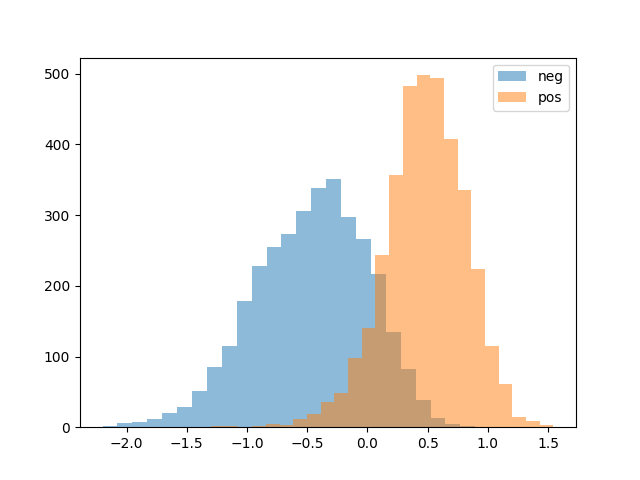

In [1]:
from IPython.display import Image
Image("../../img/sst_binary_sentiment_unit_vis.png")

In [2]:
import sys
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../generating-reviews-discovering-sentiment/")
from encoder import Model

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from IPython import display
from IPython.core.magic import register_cell_magic, Magics, magics_class, cell_magic
import jinja2

# Code imported from https://gist.github.com/bj0/5343292 for html representation of text sentiment 
# within jupyter notebook

@magics_class
class JinjaMagics(Magics):
    '''Magics class containing the jinja2 magic and state'''
    
    def __init__(self, shell):
        super(JinjaMagics, self).__init__(shell)
        
        # create a jinja2 environment to use for rendering
        # this can be modified for desired effects (ie: using different variable syntax)
        self.env = jinja2.Environment(loader=jinja2.FileSystemLoader('.'))
        
        # possible output types
        self.display_functions = dict(html=display.HTML, 
                                      latex=display.Latex,
                                      json=display.JSON,
                                      pretty=display.Pretty,
                                      display=display.display)

    
    @cell_magic
    def jinja(self, line, cell):
        '''
        jinja2 cell magic function.  Contents of cell are rendered by jinja2, and 
        the line can be used to specify output type.

        ie: "%%jinja html" will return the rendered cell wrapped in an HTML object.
        '''
        f = self.display_functions.get(line.lower().strip(), display.display)
        
        tmp = self.env.from_string(cell)
        rend = tmp.render(dict((k,v) for (k,v) in self.shell.user_ns.items() 
                                        if not k.startswith('_') and k not in self.shell.user_ns_hidden))
        
        return f(rend)
        
    
ip = get_ipython()
ip.register_magics(JinjaMagics)

def extract_color(value):
    cmap = plt.get_cmap("RdYlGn")
    value_norm = 
    
    return 'rgb({},{},{})'.format(255, 255-int(value*255), 255-int(value*255))

def build_sequence_visualizer(text, sentiment):
    characters = list(text)
    values = pd.DataFrame({'char': characters, 'sentiment': sentiment})
    minn = values['sentiment'].min()
    maxn = values['sentiment'].max()
    values['sentiment'] = (values['sentiment'] - minn) / (maxn - minn)
    values['color'] = values['sentiment'].apply(lambda x: extract_color(x))
    return values



### Extract sentiment with the pre-trained LSTM model (neuron 2388) - PyTorch version

#### QA model with Sutskever et al. 2017 example sentences

In [158]:
file = open("../../data/sentiment_control_pytorch.pkl",'rb')
control_sentences = pickle.load(file)

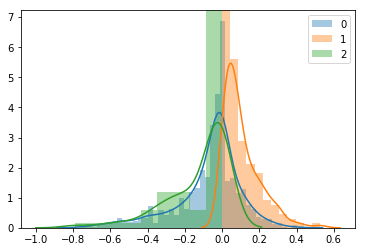

In [193]:
values = []
for i, sentence in enumerate(control_sentences):
    value = build_sequence_visualizer(sentence['text'], sentence['sentiment'])
    value = value.loc[:,('char','color')].to_dict('records')
    values.append(value)

    sns.distplot(sentence['sentiment'], label=str(i))
    plt.legend()

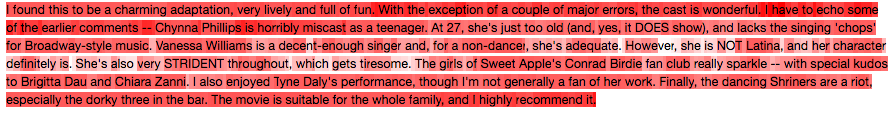

In [195]:
#%%jinja html
#<html>
#<body>
#{% for r in values[0] %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>
Image("../../img/text0.png")

In [32]:
Image("../../img/text1.png")

In [33]:
Image("../../img/text2.png")

The model seems to work well since clearly control sentence 1 is more positive and control sentence 2 is more negative.

### Evaluate sentiment of migration related selected articles from Spiegel

I took less than 6h to predict the sentiment of the 330 articles in a macbook air: 4 cores 4GB. This is around 19.2 times less than the Tensor Flow version.

In [6]:
# load correctly labeled selected articles or get list of indexes ordered by date
selected_articles = pd.read_csv("../../data/330_selected_art_translated_correct.csv")
order_articles_asc = selected_articles.sort_values(by='date_x').index.tolist()
se_order_art_to_quarter = selected_articles.sort_values(by='date_x').quarter

In [7]:
file = open("../../data/sentiment_selection_pytorch.pkl",'rb')
sentences_sentiment = pickle.load(file)
sentiment_pytorch = [element['sentiment'] for element in sentences_sentiment]
texts_pytorch = [element['text'] for element in sentences_sentiment]

In [8]:
# shape results array with sentiment per article to be readable
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment_pytorch)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

# Calculate absolute values for evaluation of the sentiment intensity
tmp_ordered['sentiment_abs'] = tmp_ordered['sentiment'].apply(lambda x: abs(x))

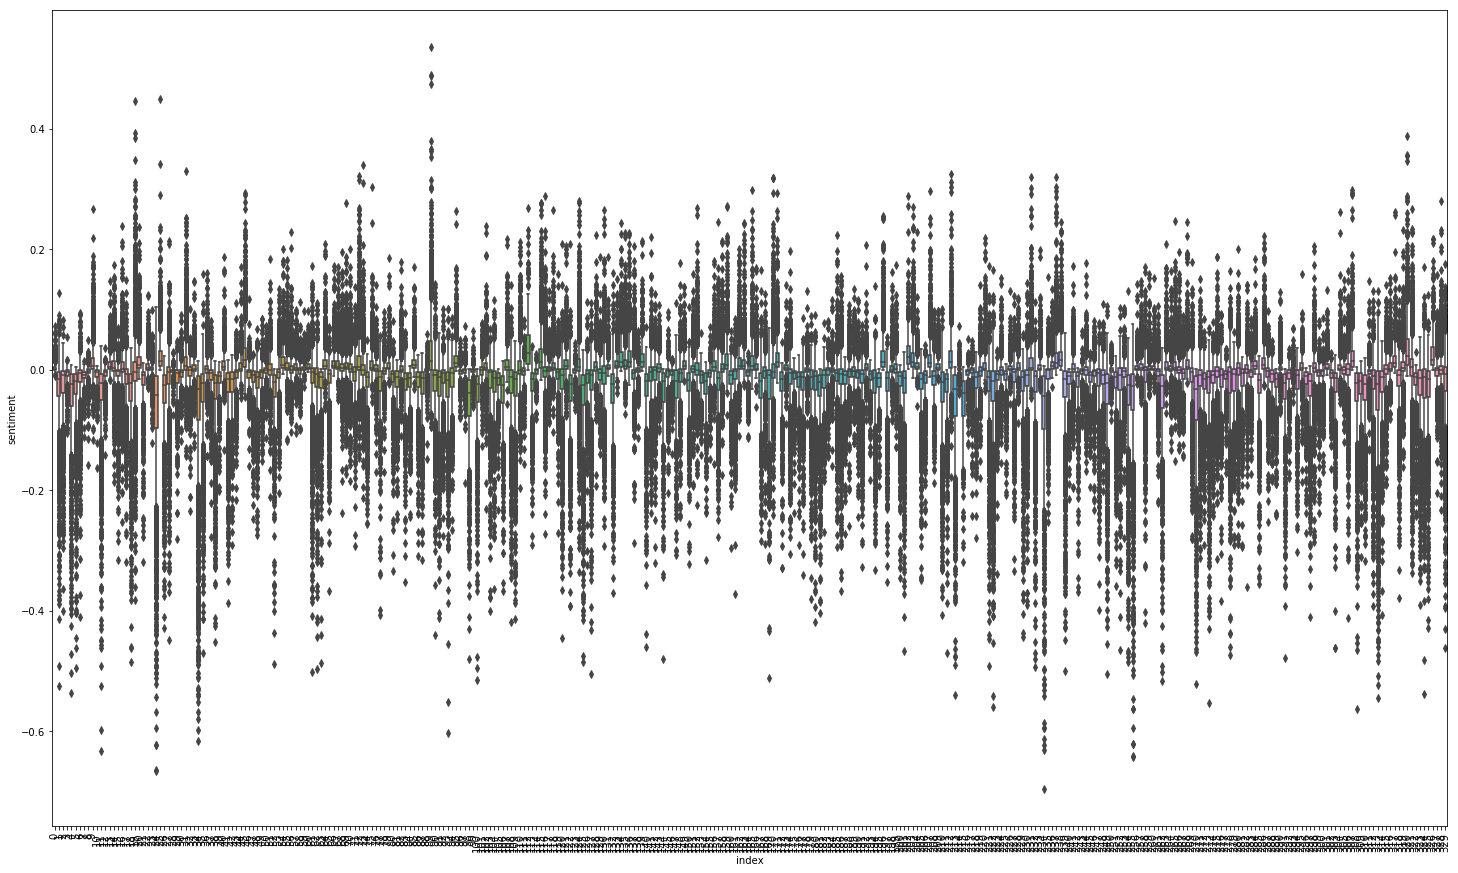

In [17]:
_=plt.figure(figsize=(25, 15))
_=sns.boxplot(data=tmp_ordered, x='index', y='sentiment')
_=plt.xticks(rotation=90)

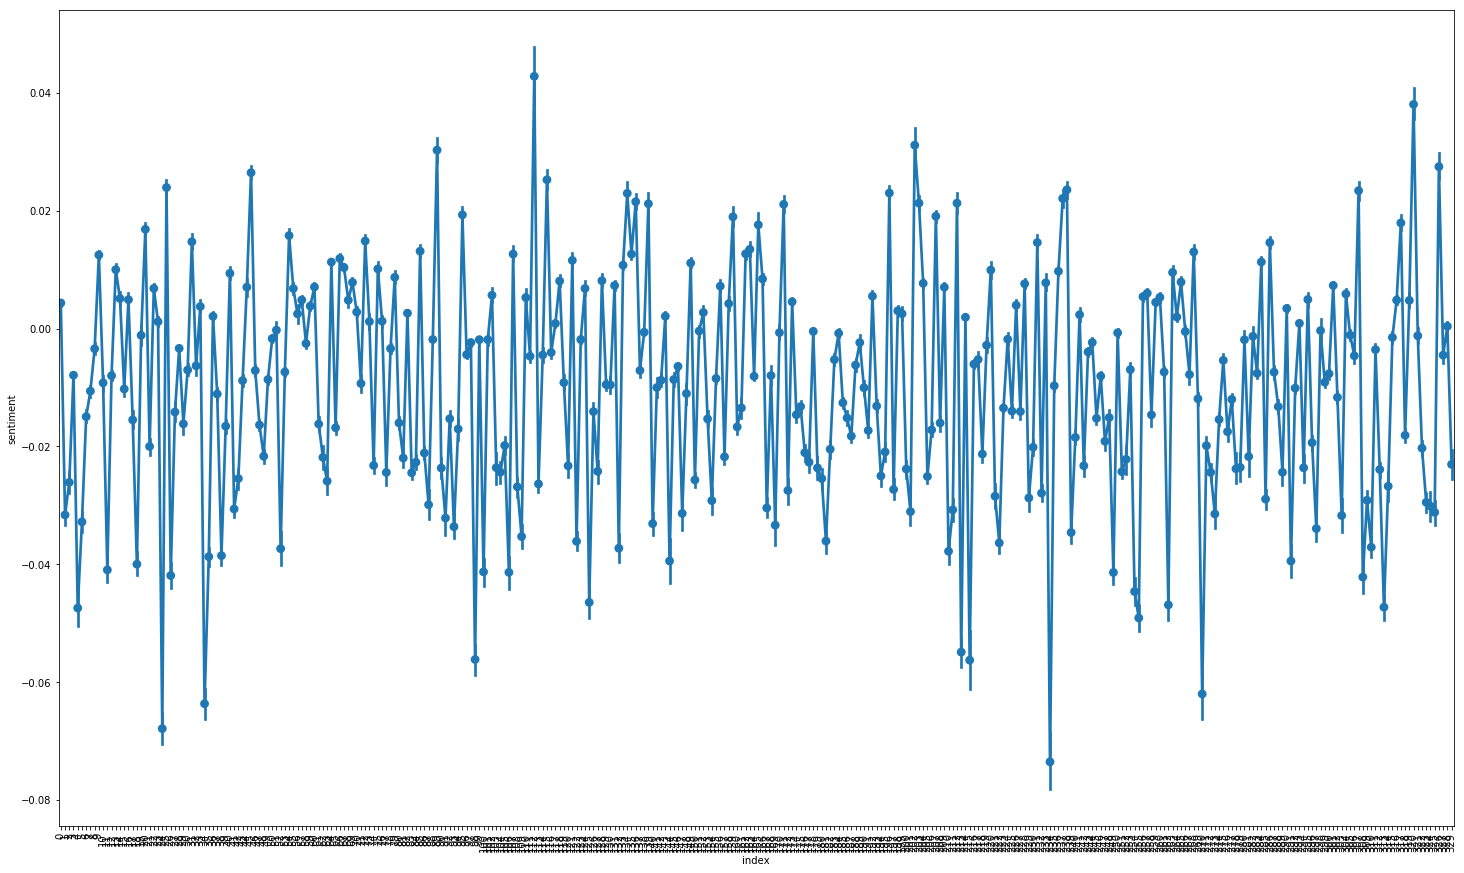

In [36]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered, x='index', y='sentiment')
_=plt.xticks(rotation=90)

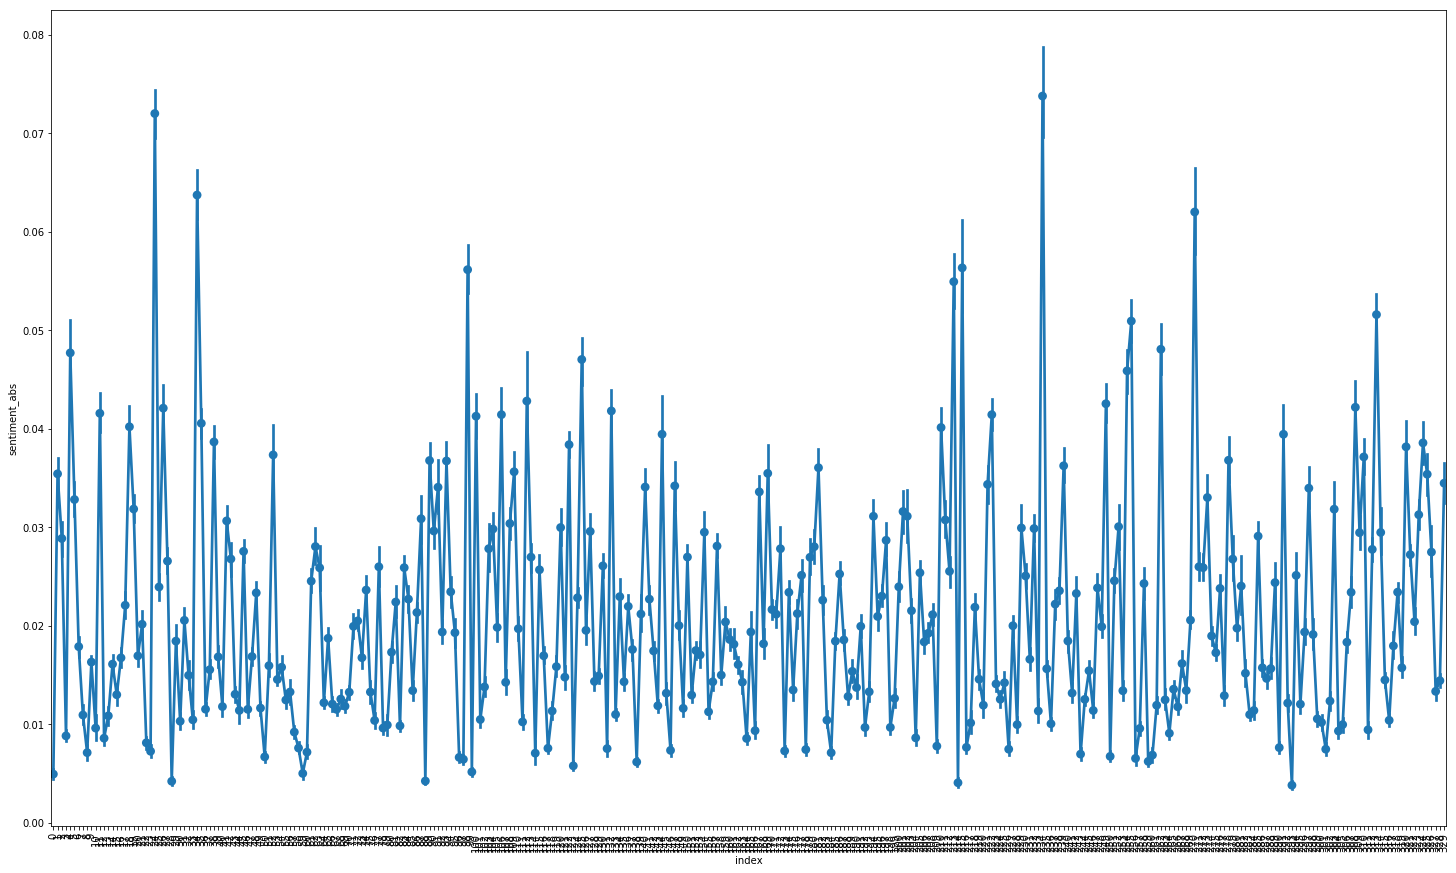

In [13]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered, x='index', y='sentiment_abs')
_=plt.xticks(rotation=90)

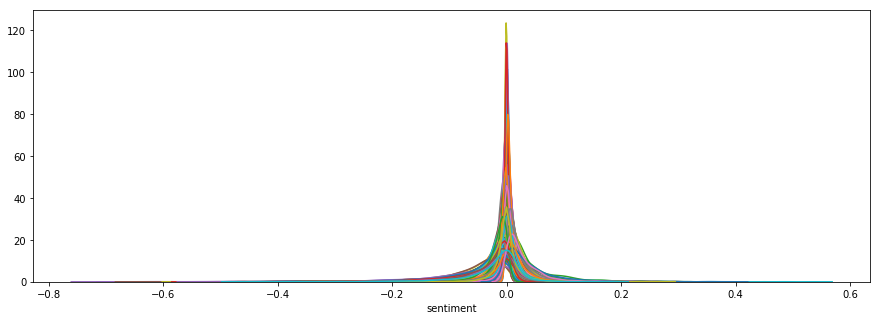

In [19]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.a_idx.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

In [134]:
mean_sentiment = tmp_ordered.groupby(['a_idx'], as_index=False).std()
mean_sentiment.sort_values(by='sentiment', ascending=False).head()

,a_idx,sentiment,index,sentiment_abs
297,17.233688,0.094936,0.0,0.094737
70,8.366600,0.086486,0.0,0.083092
98,9.899495,0.083378,0.0,0.083326
304,17.435596,0.078956,0.0,0.078953
57,7.549834,0.071171,0.0,0.068109


###### Sentiment per quarter

In [10]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

In [21]:
len(se_order_art_to_quarter)

330

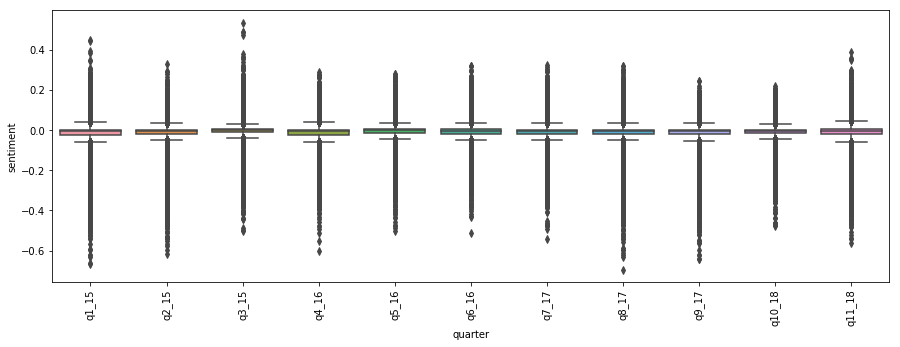

In [22]:
_=plt.figure(figsize=(15, 5))
_=sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')
_=plt.xticks(rotation=90)

In [40]:
a = tmp_ordered.loc[:,['quarter','sentiment']]
a['label'] = 'average sentiment'
b = tmp_ordered.loc[:,['quarter','sentiment_abs']].rename(columns={'sentiment_abs':'sentiment'})
b['label'] = 'absolute sentiment'
c = tmp_ordered.loc[tmp_ordered[tmp_ordered['sentiment']>=0].index,['quarter','sentiment']]
c['label'] = 'positive sentiment'
d = tmp_ordered.loc[tmp_ordered[tmp_ordered['sentiment']<0].index,['quarter','sentiment']]
d['label'] = 'negative sentiment'
complete = pd.concat([a,b,c,d])

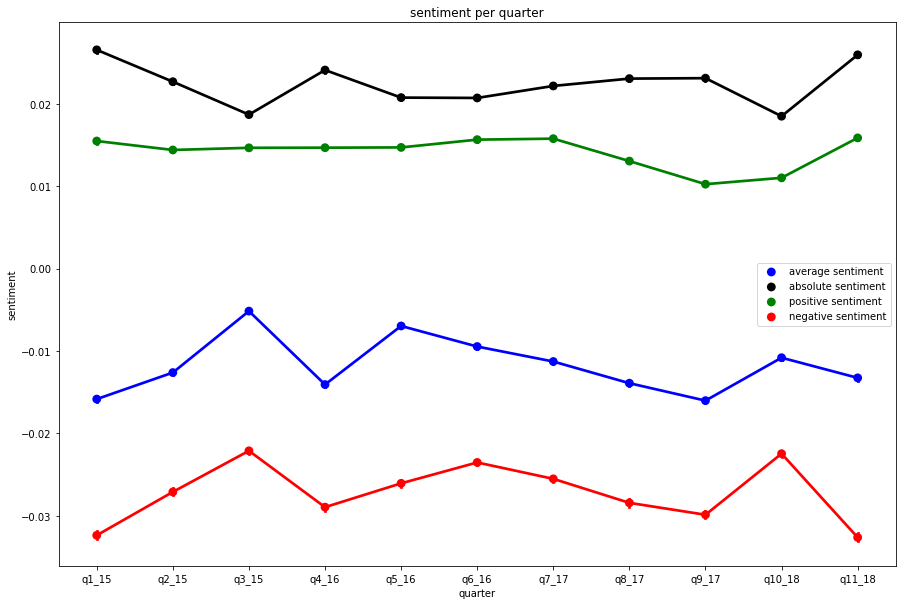

In [42]:
_=plt.figure(figsize=(15, 10))
_=sns.pointplot(data=complete, x='quarter', y='sentiment', hue='label', palette=['blue','black','green','red'])
_=plt.title('sentiment per quarter')
_=plt.legend()

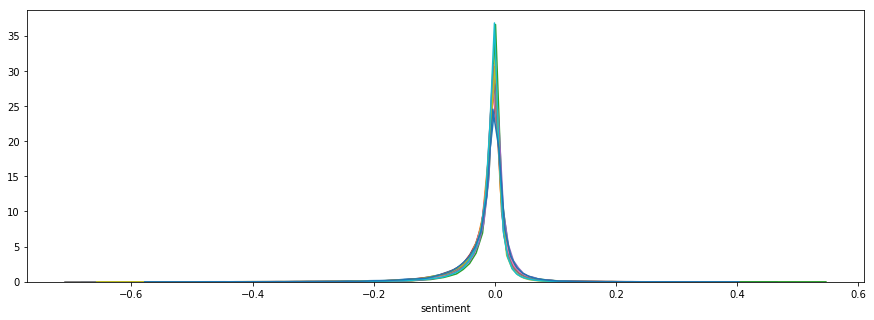

In [24]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)

### See detailed sentiment in most positive and most negative articles

In [157]:
# See most average most positive and most negative articles
positive_article_a_idx = [58,170,292]
negative_article_a_idx = [70,297,165]

texts = []
sentiments = []
for i in [0,1,2]:
    texts.append(texts_pytorch[positive_article_a_idx[i]])
    texts.append(texts_pytorch[negative_article_a_idx[i]])
    sentiments.append(sentiment_pytorch[positive_article_a_idx[i]])
    sentiments.append(sentiment_pytorch[negative_article_a_idx[i]])

# add neutral article
neutral_Article_a_idx = 38
texts.append(texts_pytorch[neutral_Article_a_idx])
sentiments.append(sentiment_pytorch[neutral_Article_a_idx])
    
# Fix missmatch because of rare characters
sentiment_correct = []
for i, sentiment in enumerate(sentiments):
    if i == 0:
        sentiment = sentiment[2:-2]
    elif i == 1:
        sentiment = sentiment[3:-3]
    elif i == 2:
        sentiment = sentiment[:-1]
    elif i == 6:
        sentiment = sentiment[2:-2]
    sentiment_correct.append(sentiment)

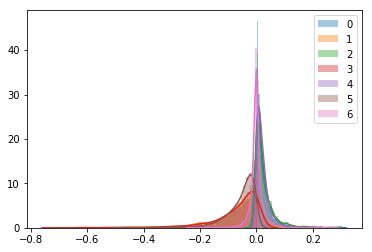

In [158]:
values = []
for i, sentence in enumerate(texts):
    value = build_sequence_visualizer(sentence, sentiment_correct[i])
    value = value.loc[:,('char','color')].to_dict('records')
    values.append(value)

    sns.distplot(sentiment_correct[i], label=str(i))
    plt.legend()

In [159]:
[np.mean(i) for i in sentiments]

[0.023409214494762166,
 -0.067897817037220323,
 0.025264963214374197,
 -0.073527083714926347,
 0.023560688614341067,
 -0.056156293700819919,
 0.00039387212583750407]

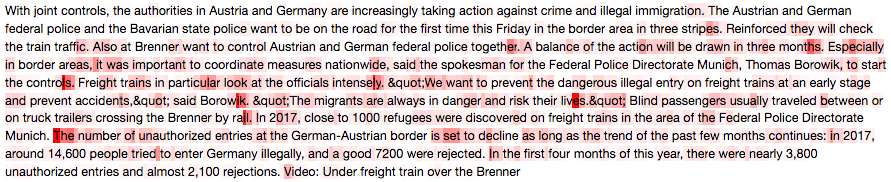

In [207]:
#%%jinja html
#<html>
#<body>
#{% for r in values[0] %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>
Image("../../img/article0.png")

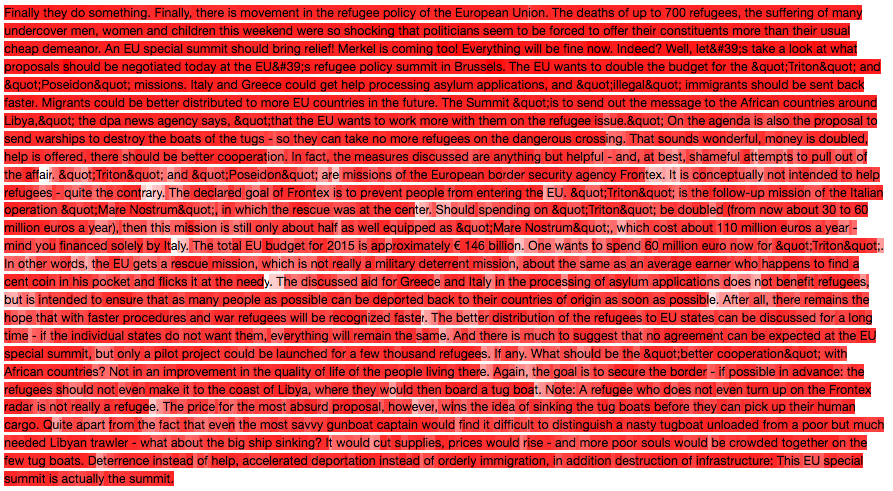

In [208]:
Image("../../img/article1.png")

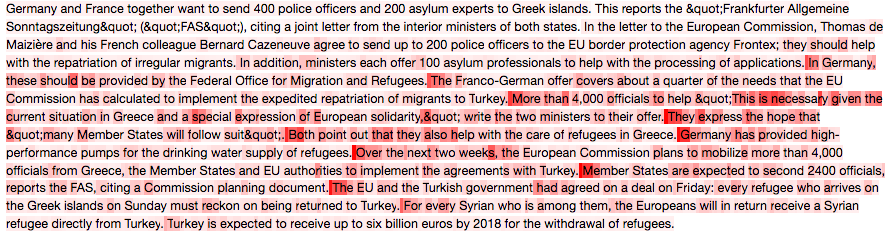

In [209]:
Image("../../img/article2.png")

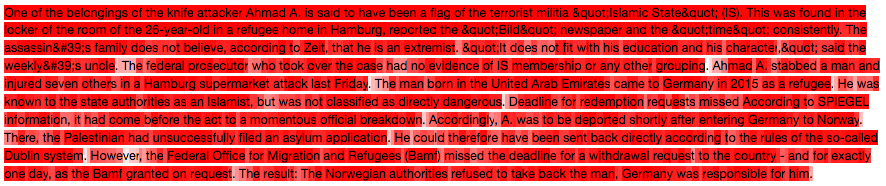

In [210]:
Image("../../img/article3.png")

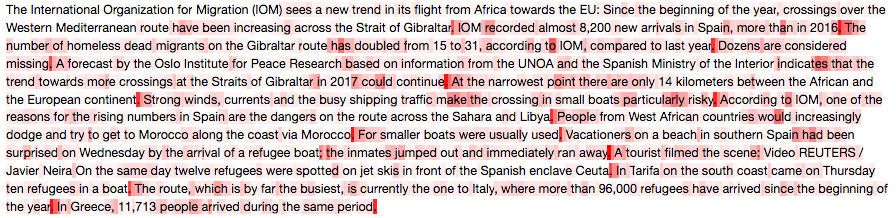

In [211]:
Image("../../img/article4.png")

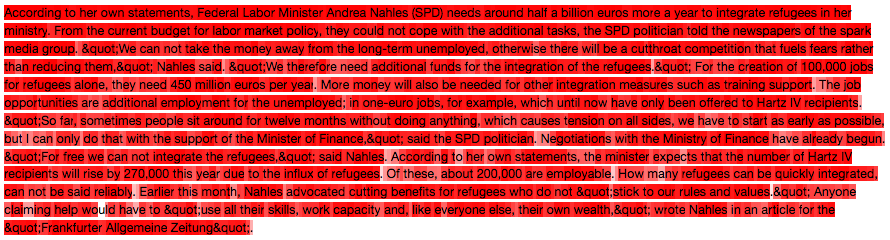

In [212]:
Image("../../img/article5.png")

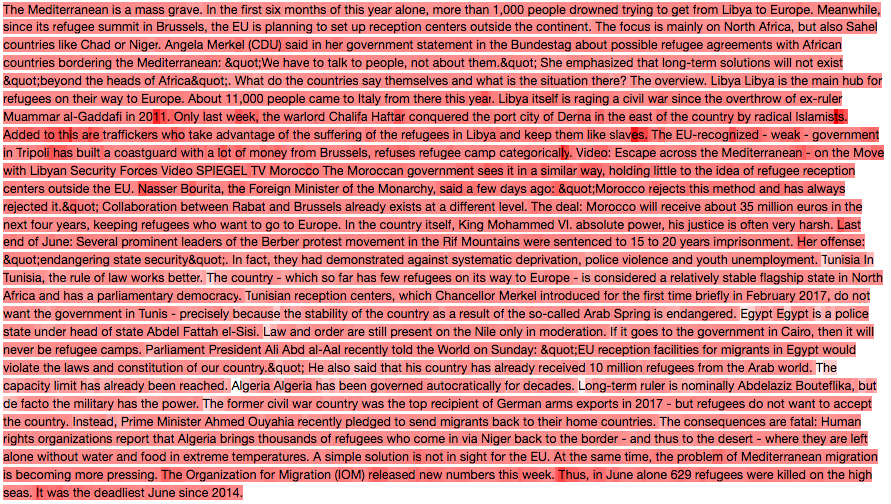

In [66]:
Image("../../img/article6.png")

### Extract sentiment with the pre-trained LSTM model (neuron 2388) - Tensor Flow version

#### QA model with Sutskever et al. 2017 example sentences

In [41]:
# Sentences mentioned in Sutskever et al. 2017 to check if results are reproducible
control_texts = [
    "I found this to be a charming adaptation, very lively and full of fun. With the exception of a couple of major errors, the cast is wonderful. I have to echo some of the earlier comments -- Chynna Phillips is horribly miscast as a teenager. At 27, she's just too old (and, yes, it DOES show), and lacks the singing 'chops' for Broadway-style music. Vanessa Williams is a decent-enough singer and, for a non-dancer, she's adequate. However, she is NOT Latina, and her character definitely is. She's also very STRIDENT throughout, which gets tiresome. The girls of Sweet Apple's Conrad Birdie fan club really sparkle -- with special kudos to Brigitta Dau and Chiara Zanni. I also enjoyed Tyne Daly's performance, though I'm not generally a fan of her work. Finally, the dancing Shriners are a riot, especially the dorky three in the bar. The movie is suitable for the whole family, and I highly recommend it.",
    "Just what I was looking for. Nice fitted pants, exactly matched seam to color contrast with other pants I own. Highly recommended and also very happy!",
    "The package received was blank and has no barcode. A waste of time and money."]

In [42]:
# Initialize an instance of the model
model = Model(root_path="/Users/celsadiaz/github/generating-reviews-discovering-sentiment/")

745.678 seconds to transform 905 examples
125.863 seconds to transform 150 examples
80.720 seconds to transform 77 examples


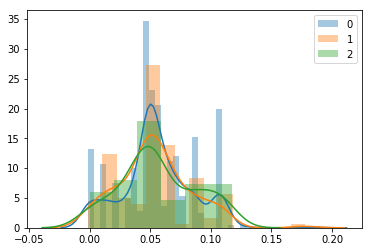

In [45]:
# Extract sentiment from each sentence
values_1 = []
sentiments = []
for i, text in enumerate(control_texts):
    text_features = model.transform(text)
    sentiment = text_features[:, 2388]
    sentiments.append(sentiment)
    
    values = build_sequence_visualizer(text, sentiment)
    values = values.loc[:,('char','color')].to_dict('records')
    values_1.append(values)
    
    sns.distplot(sentiment, label=str(i))
    plt.legend()

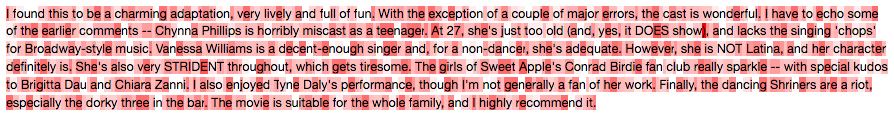

In [51]:
#%%jinja html
#<html>
#<body>
#{% for r in values_1[0] %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>
Image("../../img/text0_tf.png")

In [52]:
Image("../../img/text1_tf.png")

In [53]:
Image("../../img/text2_tf.png")

In [54]:
control_tf_version = []
for i, text in enumerate(control_texts):
    case = {}
    case['text'] = text
    case['sentiment'] = sentiments[i]
    control_tf_version.append(case)
    
pickle.dump(control_tf_version, open('../../data/sentiment_control_tensorflow.pkl', "wb"))

The prediction of the sentiment looks like totally random and it can not distinguish properly the difference between the positive and and the negative review examples presented in Sutskever et al. 2017.

### Run sentiment analysis of selected articles in Google Cloud

Performance
- macbook air: 4cores 4GB 
    - article with 319 words/2368 characters 1274.9s -> 21.2’
    - total = 30 articles/quarter x 11 quarters x 21.2' -> 4.8 days
- GC: 4CPUs 15GB
    - article with 319/2368 characters 479.9 -> 7.9’
    - total = 30 articles/quarter x 11 quarters x 7.9' -> 1.8 days

In [214]:
# load sentiment predicted by tensorflow version lstm model
file_100 = open("../../data/sentiment_analysis_scores_checkpoint.pkl",'rb')
file_100_on = open("../../data/sentiment_analysis_scores.pkl",'rb')
sentiment_100 = pickle.load(file_100)
sentiment_100_on = pickle.load(file_100_on)

sentiment = sentiment_100[:100] + sentiment_100_on

#### Sentiment per article evolution

In [215]:
# shape results array with sentiment per article to be readable
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

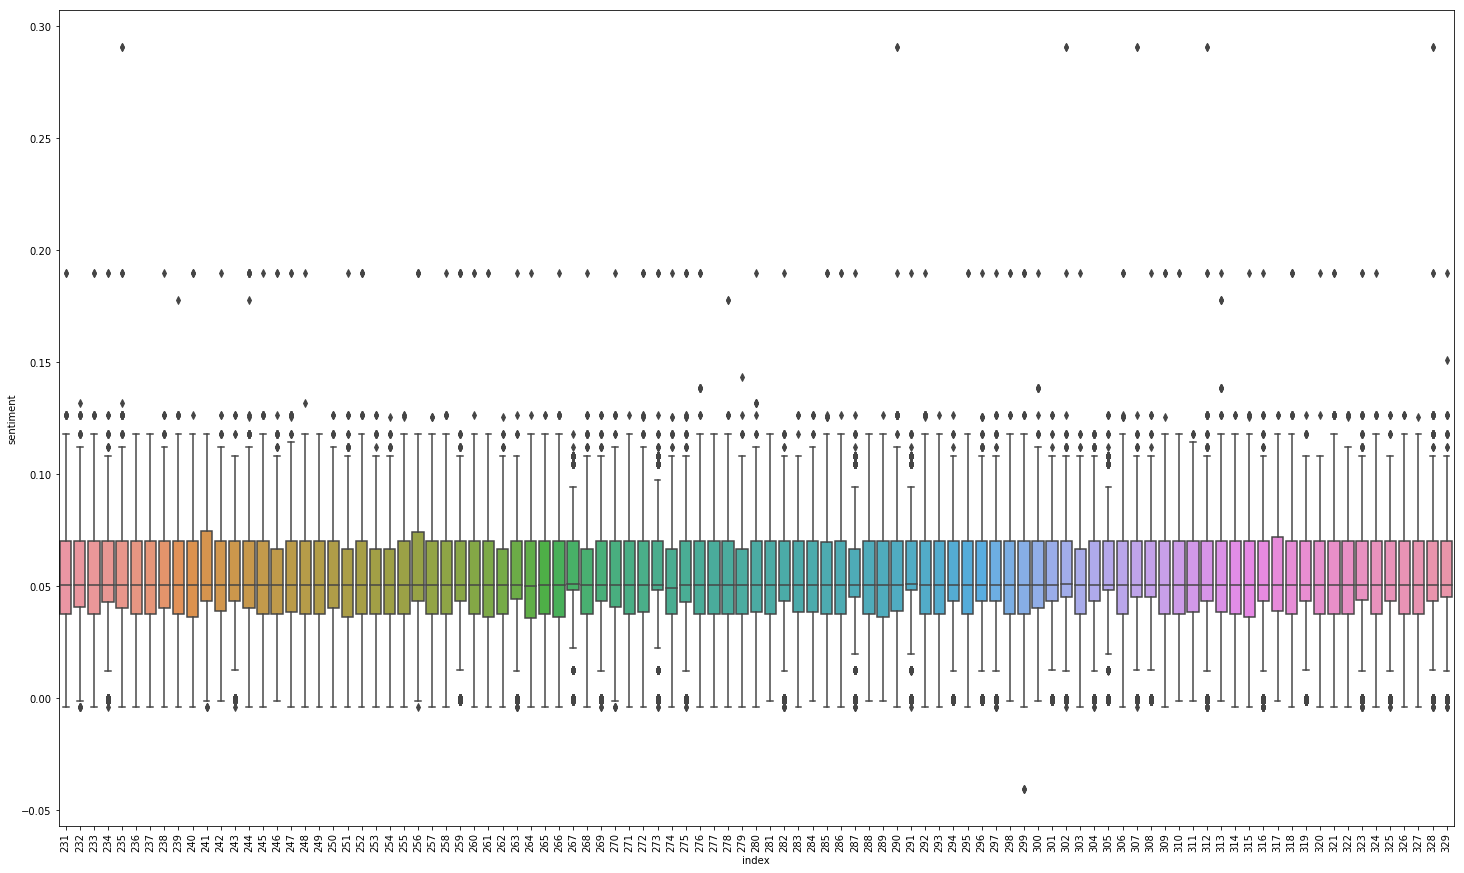

In [216]:
_=plt.figure(figsize=(25, 15))
_=sns.boxplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

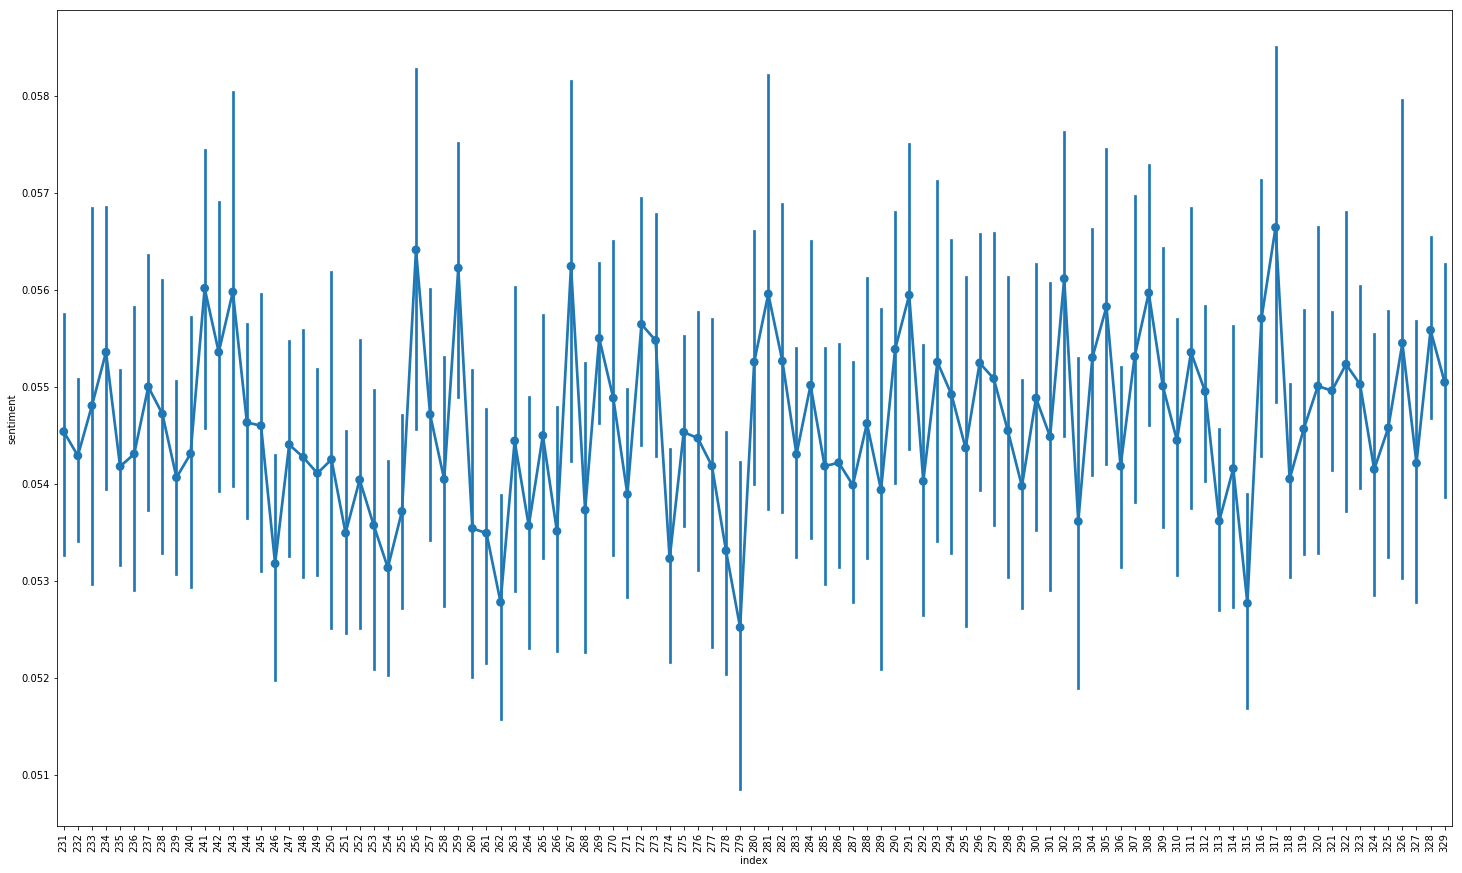

In [217]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

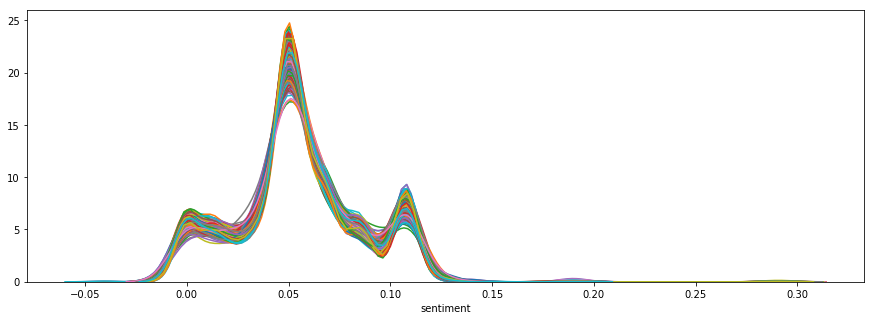

In [218]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.a_idx.unique().tolist():#[::5]:
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

#### Sentiment per quarter

In [219]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

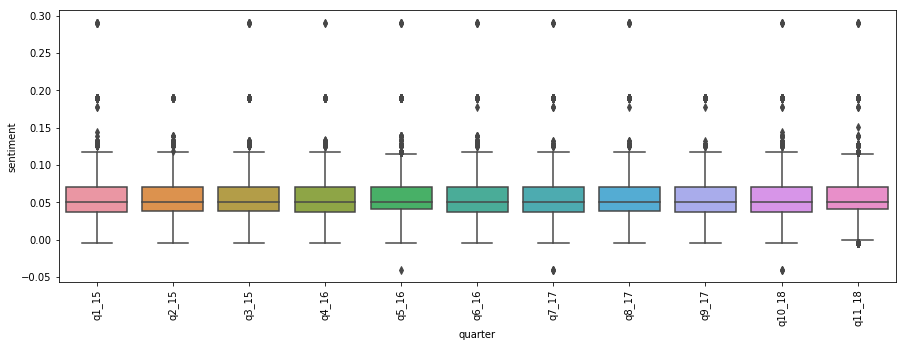

In [220]:
_=plt.figure(figsize=(15, 5))
_=sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')
_=plt.xticks(rotation=90)

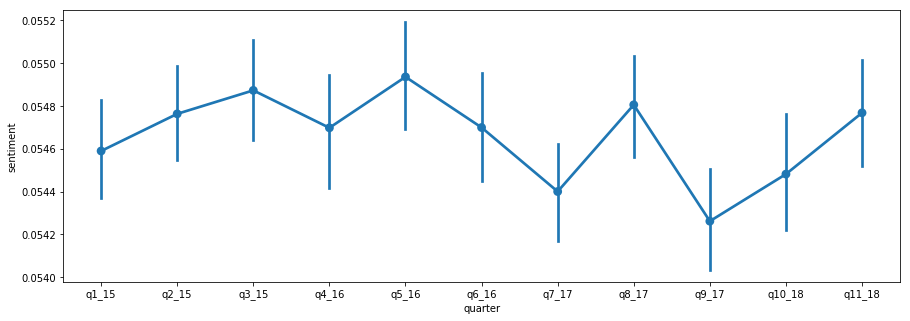

In [221]:
_=plt.figure(figsize=(15, 5))
_=sns.pointplot(data=tmp_ordered, x='quarter', y='sentiment')

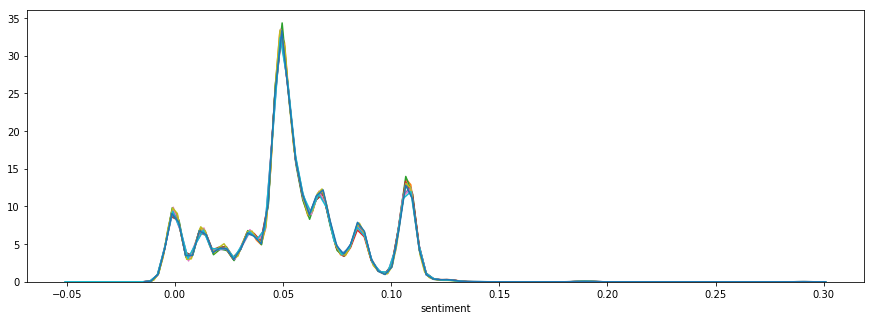

In [222]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)

### Conclusions

* The first conclusion comparing the two models is that the PyTorch version took ~19.2 times less time to compute the sentiment than the Tensor Flow version.

* Comparing again the two models, the prediction of the sentiment neuron for the TensorFlow model does not match the results presented in Sutskever et al. 2017. This may be because of the different TensorFlow version. The original repo do not specify the version used. In this work I use TensorFlow 1.4.0 with Python 3.5. On the other hand, when using the PyTorch model with PyTorch 0.4.1, the sentiment agrees with the results in the publication. The next points will be referred to the predictions obtained by the PyTorch trained model.

* Google API translations were pretty accurate and therefore, translation to english could be a good approach when lacking labeled training data in other language than english and the sample size to analyze is not large.

* In general, you may agree that migration, especially in the last years, has become one of the main concerns of europeans. Therefore, regardless of the specific topic of each article, one can expect, on average, a negative sentiment. This is exactly what we see, the average values of the sentiment per quarters are less than zero [-0.005, -0.017].

* In order to better understand the sentiment predicted, we selected the three articles with a most positive sentiment and the three with a most negative sentiment. Notice that the most positive ones have values around 0.02 and this could be considered neutral sentiment according to the distributions presented in [2]. Additionally, clear red means more positive and darker red means more negative sentiment.

* The first article (or article with label 0) talks about the need of police controls in the Austrian border because of the danger of massive illegal immigration coming. It could be classified as position against open borders to refugees. However, the style of the writer formulates the topic in such a non sensationalist and politically correct perspective, with words such as "prevent" and "reinforcement" so after reading the article the feeling is pretty neutral. On the other hand, the second article (or article with label 1), classified as one of the most negative ones, has a position defending the human rights. The author is pretty critical and targets the topic from a pretty sensationalist perspective using words such as "deaths", "suffering" or "destruction". 

* The LSTM model clearly assigns the sentiment to characters considering the memory of what happened before and after each character so the text have the correct sentiment assigned from the beginning. Despite of being trained with Amazon Reviews, it understand the meaning of a sentence such as "The migrants are always in danger and risk their lives" since the negative sentiment is assigned to the characters in the word "lives" likely understanding the connection of "risk" and "danger" when being attributes of "lives". There are also obvious mistakes in the model such as assigning positive sentiment to words like "EU" or "German" likely because in Amazon Reviews german or european products could have a positive connotation for higher quality. In general, specific vocabulary used for products' quality description may have acquired a different connotation than when used in a different context. However, we can conclude that the model predicts pretty well the neutrality, the sensationalism, the negativity when using words with negative connotation and the other way around.

* The prediction of the position of the writer, pro or against migration, is a different feature than sentiment. Thus, we can not say that quarters with higher negative sentiment are due to the increase of publications against migration. We can say that those quarters articles were more critical against "something related to migration" when more negative. When more closed to zero we can say that "Der Spiegel" was more neutral or objective about migration topics and when analyzing the absolute value of the sentiment we can assign more sensationalism or criticism to those periods with higher values.

* We see that the most neutral periods were at the end of 2015 and after the german elections at the beginning of 2018. When considering only the positive values of the sentiment from all articles, we seen that the positive vocabulary was reduced in 2017, especially since the terrorist attack in Berlin in December 2016 until the government was formed after the german elections. When considering only negative values of the sentiment from all articles, there is a strong drop at the beginning of 2016, maybe related to the Koelln events in New Year's Eve since it matches the peak on absolute values meaning that there was an increase on the sensationalism. Finally, there is a quite sensationalist and negative moment in the current quarter of 2018. Could be due to the fight between CDU and CSU or to the critical situation of Italian and Maltese governments closing their harbors to immigrant rescue shifts.

* Back to the idea of predicting the political position of publications, pro or against migration, as mentioned, it is a different feature of the texts. For this aim, one need to train the model on more migration specific words (i.e. Populisten, Abschiebung, Deutschen, Demokratie, Kriminalität, Videoüberwachung). The problem with these positive/negative classification of words by topic is that the classification is pretty subjective and readers of "Die Bild" would consider several of them as positive whereas readers of "Taz" will consider it as negative. Therefore, it would be important to give special importance to the context where those words are used. In this case, Amazon Reviews would not be so helpful to train a LSTM model. The easiest option would be to extract the text from Twitter from people with clear political opinion about migration and assign this way the labels to the texts.

* Regarding the questions proposed at the beginning of the article, with the methodology presented here we can measure if the sentiment transmitted by the journalist about migration is positive or negative, we can even measure how neutral or sensationalist the articles are. However, we can no quantify the opinion or the political position of the texts regarding migration (whether or not immigration is seen as something positive). Additionally, we see that there are specific periods where the sentiment change. Clearly, periods that are critical for political parties like pre-election time, become more sensationalist. Furthermore, when there is a critical event such as the massive sexual assaults in New Year's Eve or a terrorist attack, the media seems to become more sensationalist, even in reference newspapers.